In [1]:
import torch
import ray
import gym
from IPython import display
import ray.rllib.agents.dqn as dqn
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
print(torch.cuda.is_available())

True


In [3]:
import logging

from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.utils.annotations import override
from ray.rllib.utils.framework import try_import_torch

torch, nn = try_import_torch()

logger = logging.getLogger(__name__)


class ConvNet(TorchModelV2, nn.Module):
    """Generic fully connected network."""

    def __init__(self, obs_space, action_space, num_outputs, model_config,
                 name):
        TorchModelV2.__init__(self, obs_space, action_space, num_outputs,
                              model_config, name)
        nn.Module.__init__(self)
        in_channels = obs_space.shape[-1]
        self._conv_layers = nn.Sequential(
            torch.nn.Conv2d(in_channels, 8, kernel_size=[7,7], padding=3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, stride=2, padding=1),
            torch.nn.Conv2d(8, 16, kernel_size=[5,5], padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, stride=2, padding=1),
            torch.nn.Conv2d(16, 32, kernel_size=[3,3], padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, stride=2, padding=1),
            torch.nn.Conv2d(32, num_outputs, kernel_size=[12,12])
        )
        self._features = None
        self._num_outputs = num_outputs

        

    @override(TorchModelV2)
    def forward(self, input_dict, state, seq_lens):
        obs = input_dict["obs"].float().permute(0,3,1,2) #reshape input
        self._features = self._conv_layers(obs).view(-1, self._num_outputs)
        return self._features, state


In [4]:
from ray.tune.registry import register_env
from ray.rllib.agents import dqn
import numpy as np
class MultiFrameBreakout(gym.Env):
    def __init__(self, env_config):
        self.env = gym.make('Breakout-v0')
        self.action_space = self.env.action_space
        self.observation_space = self.env.observation_space
    def reset(self):
        return self.env.reset()
    def step(self, action):
        return self.env.step(action)

In [5]:
#RLLIB DEFAULT

from ray.rllib.agents import dqn

config = dqn.DEFAULT_CONFIG.copy()
config['framework'] = 'torch'
trainer = dqn.DQNTrainer(env='Breakout-v0', config=config)
policy = trainer.get_policy()
model = policy.q_model
env = trainer.workers.local_worker().env
print(env.observation_space)
"""for i in range(100):
    print(trainer.train()['episode_reward_mean'])"""

Install gputil for GPU system monitoring.


Box(0, 255, (84, 84, 4), uint8)


"for i in range(100):\n    print(trainer.train()['episode_reward_mean'])"

In [ ]:
#CUSTOM ENVIRONMENT

register_env("multiframe", lambda config: MultiFrameBreakout(config))
config = dqn.DEFAULT_CONFIG.copy()
config['framework'] = 'torch'
config['num_gpus'] = 2
trainer = dqn.DQNTrainer(env='multiframe', config=config)
policy = trainer.get_policy()
model = policy.q_model

env = trainer.workers.local_worker().env
print(env.observation_space)
"""for i in range(100):
    print(trainer.train()['episode_reward_mean'])"""

In [4]:
#CUSTOM MODEL

from ray.rllib.models import ModelCatalog

ray.shutdown()

ModelCatalog.register_custom_model("ConvNet", ConvNet)

ray.init()
trainer = dqn.DQNTrainer(env="BreakoutNoFrameskip-v4", config={
    "framework": "torch",
    "hiddens": [256,256],
    "num_gpus": 2,
    "preprocessor_pref": "deepmind",
    "model": {
        "custom_model": "ConvNet",
        # Extra kwargs to be passed to your model's c'tor.
        "custom_model_config": {},
        "use_lstm": False,
        "framestack": True
    },
    "lr": 5e-5
})


policy = trainer.get_policy()
model = policy.q_model
print(model)
for i in range(2000):
    episode_reward_mean = trainer.train()['episode_reward_mean']
    if i % 1 == 0:
        print(episode_reward_mean)
    if i % 20 == 0:
        checkpoint = trainer.save()
        print('checkpoint saved at', checkpoint)

2020-11-01 17:52:54,872	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8265
2020-11-01 17:52:56,091	INFO trainer.py:618 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2020-11-01 17:52:59,071	WARNING util.py:39 -- Install gputil for GPU system monitoring.


ConvNet_as_DQNTorchModel(
  (_conv_layers): Sequential(
    (0): Conv2d(4, 8, kernel_size=[7, 7], stride=(1, 1), padding=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=[5, 5], stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 256, kernel_size=[12, 12], stride=(1, 1))
  )
  (advantage_module): Sequential(
    (dueling_A_0): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
      )
    )
    (dueling_A_1): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
      )
    )
    (A): Sli

KeyboardInterrupt: 

In [ ]:
#CUSTOM MODEL AND CUSTOM ENVIRONMENT

from ray.rllib.models import ModelCatalog

ray.shutdown()

ModelCatalog.register_custom_model("ConvNet", ConvNet)

ray.init()
trainer = dqn.DQNTrainer(env=MultiFrameBreakout, config={
    "framework": "torch",
    "hiddens": [256,256],
    "num_gpus": 2,
    "model": {
        "custom_model": "ConvNet",
        # Extra kwargs to be passed to your model's c'tor.
        "custom_model_config": {},
        "use_lstm": True
    },
})


policy = trainer.get_policy()
model = policy.q_model
print(model)

env = trainer.workers.local_worker().env
print(env.observation_space)
for i in range(100):
    episode_reward_mean = trainer.train()['episode_reward_mean']
    if i % 1 == 0:
        print(episode_reward_mean)
    if i % 100 == 0:
        checkpoint = trainer.save()
        print('checkpoint saved at', checkpoint)

2020-11-01 15:38:05,963	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8265
2020-11-01 15:38:07,547	WARNING util.py:39 -- Install gputil for GPU system monitoring.


Box(-1.0, 1.0, (84, 84, 3), float32)
Box(-1.0, 1.0, (84, 84, 3), float32)
ConvNet_as_DQNTorchModel(
  (_conv_layers): Sequential(
    (0): Conv2d(3, 8, kernel_size=[7, 7], stride=(1, 1), padding=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=[5, 5], stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 256, kernel_size=[12, 12], stride=(1, 1))
  )
  (advantage_module): Sequential(
    (dueling_A_0): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
      )
    )
    (dueling_A_1): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=256, o

torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
t

torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
t

torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
t

torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1

torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1

torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1

torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([

torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1

torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([3

torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1

torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([3

torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1

torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1

torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1

torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1

torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([

torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1

torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1

torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1

torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1

torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1

torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1

torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1

torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([

torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1

torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1

torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([

torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1

torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([

torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([

torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1

torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([3

torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([

torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([

torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([

torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([

torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([

torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1

torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1

torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1

torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1

torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1

1.3870967741935485
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84,

torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1

torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1

torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1

torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1

torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1

torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1

torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1

torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1

torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1

torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1

torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([

torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1

torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1

torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([

torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1

torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1

torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
1.263157894736842
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 

torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1

torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([

torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1

torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1

torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1

torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1

torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([

torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([

torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([1, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([32, 3, 84, 84])
torch.Size([

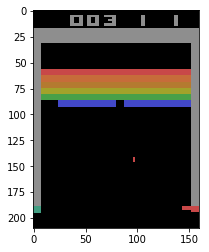

In [ ]:
from IPython import display

trainer.restore('~/bRawL/notebooks/checkpoints/BreakoutNoFrameskip_256-256_lr5e-5/checkpoint_1/checkpoint-1')
for i in range(100):
    env = trainer.workers.local_worker().env
    episode_reward = 0
    done = False
    obs = env.reset()
    hidden = [0 for i in range(512)]
    while not done:
        action = trainer.compute_action(obs)
        obs, reward, done, info = env.step(action)
        episode_reward += reward
        plt.imshow(env.render(mode='rgb_array'))
        display.display(plt.gcf())
        display.clear_output(wait=True)